# Hospital Readmission Rate Project
- Predict the probability of a patient being readmitted within 30 days 
after leaving the hospital
- Patients are diabetic encounters 
- The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes.
- Dataset and additional information: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008#

#### Libraries Used

In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Check working directory
os.getcwd()

'/Users/karolylajko/Documents/Academy/DataScienceBootcamp2020/Projects/Capstone/HealthCare/github/healthcare/dev/charlie'

In [9]:
# Checking Files within directory
os.listdir()

['.DS_Store',
 'before_model_diabdata.csv',
 'IDs_mapping.csv',
 'healthcare_final.ipynb',
 'healthcare4.ipynb',
 'diabetic_data.csv',
 'before_dummies.csv',
 'healthcare6.ipynb',
 'healthcare2.ipynb',
 '.ipynb_checkpoints',
 'healthcare5.ipynb',
 'healthcare3.ipynb']

## Helper Functions

In [10]:
# Plot Correlation Matrix
def plot_corr_matrix(df, nr_c, targ) :
    
    corr     = df.corr()
    corr_abs = corr.abs()
    cols     = corr_abs.nlargest(nr_c, targ)[targ].index
    cm       = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 12}, 
                yticklabels=cols.values, xticklabels=cols.values,cmap="OrRd")
    plt.show()

# IDC9 codes to diseases 
def idc_to_group (idcnum):
    # Hearth problems
    # External injury and suppl. class - generate 4 digit number - eval to other
    idcnum = idcnum.replace('V','9999').replace('E','9999').replace('?','9999')
    idcnum = float(idcnum) 
    if   390 <= idcnum <= 459 or idcnum == 785:
        diag = 'circulatory'
    # Lung issues
    elif 460 <= idcnum <= 519 or idcnum == 786:
        diag = 'respiratory'
    # Digestive - oral, stomac, abdominal, liver
    elif 520 <= idcnum <= 579 or idcnum == 787:
        diag = 'digestive'
    # Diabetes
    elif int(idcnum) == 250:
        diag = 'diabetis'
    # Injury or poisioning
    elif 800 <= idcnum <= 999:
        diag = 'injury'
    # Musc. system or connective tissue
    elif 710 <= idcnum <= 739:
        diag = 'musculoskeletal'
    # Kidney, urinary and genitals
    elif 580 <= idcnum <= 629 or idcnum == 788:
        diag = 'genitourinary'
    # Abnormal tissue Growth
    elif 140 <= idcnum <= 239 or idcnum in [780,781,782,784,790,791,792,793,794,795,796,797,798,799]:
        diag = 'neoplasms' 
    # Metabolic, immunity issue with no diabetes
    elif (240 <= idcnum <= 279 and idcnum != 250) or (680 <= idcnum <= 790):
        diag = 'neoplasms'
    elif 1 <= idcnum <= 139: 
        diag = 'neoplasms'
     # Other    
    else:
        diag = 'other'   
    return diag

# Convert age range to age average
def age_to_aveage (age):
    ages = ['[0-10)','[10-20)','[20-30)','[30-40)','[40-50)','[50-60)','[60-70)','[70-80)','[80-90)','[90-100)']
    newage = ages.index(age)*10+5
    return newage

# Dummify a categorical variable column
# df - dataframe
# var - variable/feature string
# Prefix for dummies - string
# def makedummies(df,var, pre_fix = 'Class'):
#     Z = pd.get_dummies(df[var], prefix = pre_fix)
#     df_dummified = pd.concat((df.drop(var,1,inplace=True), Z), axis=1)
#     return df_dummified


# Patient either transferred home (healthy) or other care continues
def conv_disch_id(did):
    try: 
        if    did == 1: 
            result = 'home'
        else:
            result = 'other'
        return result
    except ValueError:
        print('Source ID must be interger!')
        
# Convert admission source ID to category groups
def conv_adms_id(sid):
    try: 
        if    sid == 7: 
            result = 'emergency'
        elif  sid == 1:
            result = 'phys_ref'
        elif sid  == 4:
            result = 'hospital'
        elif sid ==  6:
            result = 'snf'
        elif sid ==  2:
            result = 'clin_ref'
        else:
            result = 'other'
        return result
    except ValueError:
        print('Source ID must be interger!')

In [11]:
print('Reading in CSV files')
diabdata = pd.read_csv('diabetic_data.csv')
idmapping = pd.read_csv('IDs_mapping.csv')

Reading in CSV files


In [6]:
diabdata.shape

(101766, 50)

In [296]:
diabdata.sample(7)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
9887,42459558,91345860,Caucasian,Female,[60-70),?,1,1,7,2,...,No,No,No,No,No,No,No,No,No,NO
69705,198658332,93209733,Caucasian,Female,[50-60),?,2,1,1,4,...,No,No,No,No,No,No,No,No,Yes,>30
8354,37911216,981198,Caucasian,Female,[60-70),?,1,1,7,3,...,No,Steady,No,No,No,No,No,No,Yes,NO
73805,218874960,58414545,Asian,Female,[50-60),?,1,1,7,3,...,No,Steady,No,No,No,No,No,No,Yes,NO
97471,389058356,42627546,?,Female,[50-60),?,1,1,7,4,...,No,Up,No,No,No,No,No,Ch,Yes,>30
47423,145798980,25166718,Caucasian,Male,[20-30),?,3,6,1,7,...,No,Up,No,No,No,No,No,Ch,Yes,NO
96195,372047384,135627278,Other,Female,[40-50),?,1,1,7,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [297]:
# Generating the indexes for the numerical and categorical variables
# This may be misleading as features contain numerical encoded categories
categorical_idx = diabdata.dtypes[diabdata.dtypes=='object'].index
numerical_idx   = diabdata.dtypes[diabdata.dtypes!='object'].index

In [298]:
print('The unique number of patients, keeping those observations eventually ')
diabdata.patient_nbr.value_counts().count()

The unique number of patients, keeping those observations eventually 


71518

## Feature Overview

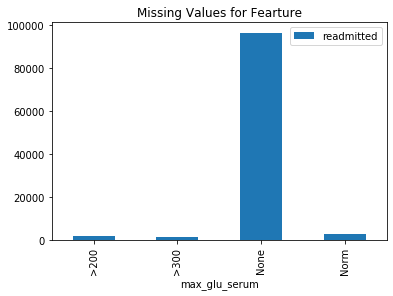

In [299]:
diabdata[['max_glu_serum','readmitted']].groupby(['max_glu_serum']).count().plot.bar(title='Missing Values for Fearture')

In [300]:
# There is a cvs file to decode ID fields used later
idmapping.transpose().head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
admission_type_id,1,2,3,4,5,6,7,8,NaN,discharge_disposition_id,...,17,18,19,20,21,22,23,24,25,26
description,Emergency,Urgent,Elective,Newborn,Not Available,NaN,Trauma Center,Not Mapped,NaN,description,...,NaN,Transfer From Another Home Health Agency,Readmission to Same Home Health Agency,Not Mapped,Unknown/Invalid,Transfer from hospital inpt/same fac reslt in...,Born inside this hospital,Born outside this hospital,Transfer from Ambulatory Surgery Center,Transfer from Hospice


### ID Fields for admission and discharge types
- The ID fields are integers but they are codes that need to be decoded and grouped into categories. Need one hot encoding after. 
- idmapping.csv file contains details

admission_type_id: 

 1: 'Emergency',
 2: 'Urgent',
 3: 'Elective',
 4: 'Newborn',
 5: 'Not Available',
 6: nan,
 7: 'Trauma Center',
 8: 'Not Mapped'

discharge_disposition_id:

1: Discharged to Home
2: Another Hospital
3: Transferred a Skilled Nurse Fascility (SNF)
4: Transferred a Intensive Care Fasc. (ICF)
5: Transferred a Impatient Care Inst.
6: Transferred to Home with Home Health
11: Expired/Death
18: NULL
25: Not Mapped

admission_source_id:

1: Physician Referral
2: Clinic Referral
3: HMO Referral
4: Transfer from a hospital
5: Transfer from a Skilled Nursing Facility (SNF)
6: Transfer from another health care facility
7: Emergency Room
9: Not Available
17: NULL
20: Not Mapped



In [301]:
# Check where patients were released after hospital care - create groups 
diabdata.discharge_disposition_id.value_counts()[:10]

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
Name: discharge_disposition_id, dtype: int64

In [302]:
# Check how patients were patients were admitted - covert IDs and group within feature
diabdata.admission_source_id.apply(lambda x: conv_adms_id(x))

0          phys_ref
1         emergency
2         emergency
3         emergency
4         emergency
            ...    
101761    emergency
101762        other
101763    emergency
101764    emergency
101765    emergency
Name: admission_source_id, Length: 101766, dtype: object

In [303]:
# To map dictionary values to panda df columns keys set 1 -to - ID
def fix_dict_keys(mydict):
    j = 1
    temp_dict={}
    for key in mydict: 
        temp_dict[j] = mydict[key]
        j+=1
    return temp_dict
# --------------------------------------------------
# Extract the ID information from mapping data frame

# admission_type_id
ad_type_id_dict    = idmapping.iloc[0:8,]['description'].to_dict()

# discharge_disposition_id
discharge_id_dict  = idmapping.iloc[10:41,]['description'].to_dict()

# admission_source_id
adm_source_id_dict = idmapping.iloc[43:,]['description'].to_dict()

map_adm_type     = fix_dict_keys(ad_type_id_dict)
map_disch_type   = fix_dict_keys(discharge_id_dict)
map_source_type  = fix_dict_keys(adm_source_id_dict)

map_adm_type

{1: 'Emergency',
 2: 'Urgent',
 3: 'Elective',
 4: 'Newborn',
 5: 'Not Available',
 6: nan,
 7: 'Trauma Center',
 8: 'Not Mapped'}

## Univariate Data analysis
- Analyzing the features individually

In [304]:
diabdata.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [305]:
print('Some of the patiets are readmitted within or after 30 days.')
diabdata.readmitted.value_counts()

Some of the patiets are readmitted within or after 30 days.


NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [306]:
diabdata.diabetesMed.value_counts()

Yes    78363
No     23403
Name: diabetesMed, dtype: int64

In [307]:
print('Numerous categorical features')
# diabdata.dtypes

Numerous categorical features


In [308]:
print('The different types of data in the dataset: \n',diabdata.dtypes.value_counts())


The different types of data in the dataset: 
 object    37
int64     13
dtype: int64


Text(0.5, 1.0, 'Time spent inn Hospital VS. Readmission')

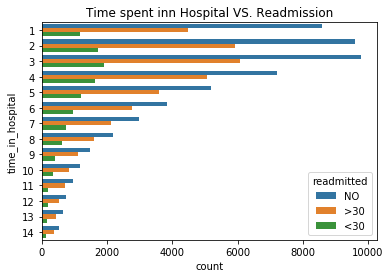

In [309]:
sns.countplot(y= diabdata['time_in_hospital'], hue = diabdata['readmitted']).set_title('Time spent inn Hospital VS. Readmission')

Text(0.5, 1.0, 'Hemoglobin Test at Admission')

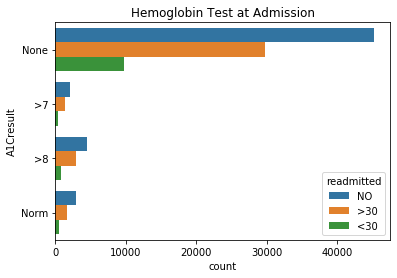

In [310]:
sns.countplot(y= diabdata['A1Cresult'], hue = diabdata['readmitted']).set_title('Hemoglobin Test at Admission')

Text(0.5, 1.0, 'Num of Procedures vs. Readmission')

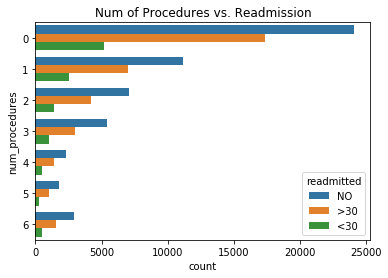

In [311]:
sns.countplot(y= diabdata['num_procedures'], hue = diabdata['readmitted']).set_title('Num of Procedures vs. Readmission')

###  Data Cleaning - Visualization - Feature Engineering

- Filtering, Imputing Missing Values
- Observing Outliers and Distribution on Graphs
- Converting data types
- Grouping features


In [312]:
# Filtering rows by dropping fields with quesiton mark '?'
# diagnostic codes, gender, dischage 
drop_Idx = set()
drop_Idx = drop_Idx.union(set(diabdata[diabdata['diag_1']                   == '?'].index)) # Unknown
drop_Idx = drop_Idx.union(set(diabdata[diabdata['diag_2']                   == '?'].index)) # Unknown
drop_Idx = drop_Idx.union(set(diabdata[diabdata['diag_3']                   == '?'].index)) # Unknown
drop_Idx = drop_Idx.union(set(diabdata[diabdata['discharge_disposition_id'] == 11].index))  # Death
drop_Idx = drop_Idx.union(set(diabdata[diabdata['gender']                   == 'Unknown/Invalid'].index))

new_Idx = list(set(diabdata.index) - set(drop_Idx))
diabdata = diabdata.iloc[new_Idx]

In [313]:
print('The dataset dimensions after dropping unkown values: ', diabdata.shape)

The dataset dimensions after dropping unkown values:  (98601, 50)


In [314]:
print('Missing Values per feature')
print('Top 10 variables of missing values')
diabdata.isnull().sum().sort_values(ascending=False)[:10]

Missing Values per feature
Top 10 variables of missing values


readmitted            0
num_lab_procedures    0
max_glu_serum         0
number_diagnoses      0
diag_3                0
diag_2                0
diag_1                0
number_inpatient      0
number_emergency      0
number_outpatient     0
dtype: int64

In [315]:
# Check if there are any missing values in dataset
np.sum(diabdata.isnull()).sum()

0

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

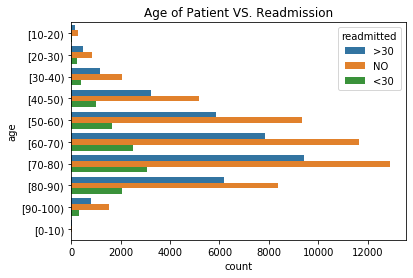

In [316]:
sns.countplot(y= diabdata['age'], hue = diabdata['readmitted']).set_title('Age of Patient VS. Readmission')

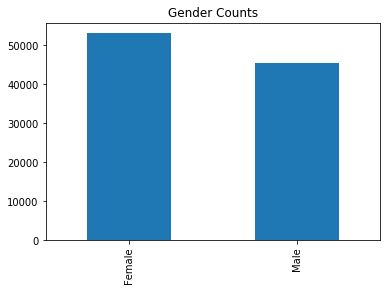

In [317]:
diabdata.gender.value_counts().plot.bar(title='Gender Counts')

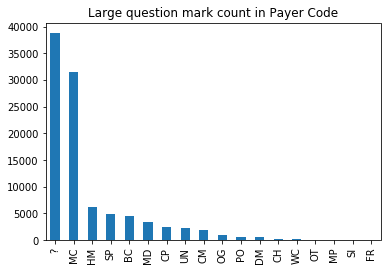

In [318]:
diabdata.payer_code.value_counts().plot.bar(title ='Large question mark count in Payer Code')

Text(0.5, 1.0, 'Race Bar Chart')

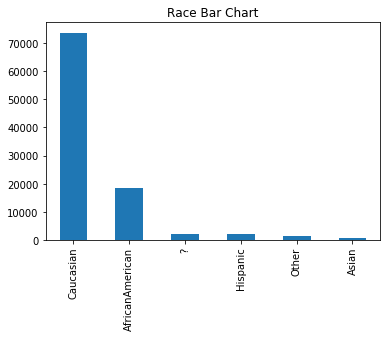

In [319]:
diabdata.race.value_counts().plot.bar().set_title('Race Bar Chart')

In [320]:
# Take care of the race missing values and minority asian as outlier
diabdata.race = diabdata.race.replace('?','Missing').replace('Asian','Other').replace('Hispanic','Other')


In [321]:
# Following guideline filling in missing for '?'
diabdata.medical_specialty  = diabdata.medical_specialty.replace('?','Missing')

In [322]:
# Convert the discharge ID codes to group of classes 
diabdata.discharge_disposition_id = diabdata.discharge_disposition_id.apply(lambda x: conv_disch_id(x))

In [323]:
# Convert the admission source ID codes to group of classes 
diabdata.admission_source_id = diabdata.admission_source_id.apply(lambda x: conv_adms_id(x))

Text(0.5, 1.0, 'Gender of Patient VS. Readmission')

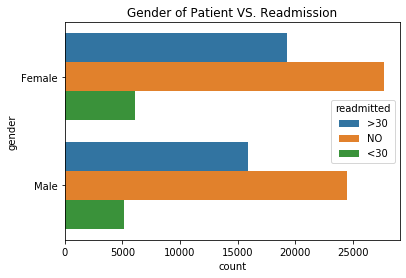

In [324]:
# Patient Gender does not have 
diabdata.gender.value_counts()
sns.countplot(y= diabdata['gender'], hue = diabdata['readmitted']).set_title('Gender of Patient VS. Readmission')

In [325]:
# Group the feature by medical specialty of the doctor

cardiology = ['Cardiology',
 'Cardiology-Pediatric']
generalpractice = ['Family/GeneralPractice']
internalmedicine = ['InternalMedicine']
missing = ['?']
surgery = ['Surgeon',
 'Surgery-Cardiovascular',
 'Surgery-Cardiovascular/Thoracic',
 'Surgery-Colon&Rectal',
 'Surgery-General',
 'Surgery-Maxillofacial',
 'Surgery-Neuro',
 'Surgery-Pediatric',
 'Surgery-Plastic',
 'Surgery-PlasticwithinHeadandNeck',
 'Surgery-Thoracic',
 'Surgery-Vascular',
 'SurgicalSpecialty']


In [326]:
diabdata.medical_specialty = ['Cardiology' if x in cardiology else
 "General Practice" if x in generalpractice else
 'Internal Medicine' if x in internalmedicine else
 'Surgery' if x in surgery else
 'Missing' if x in missing else
 'Other' for x in diabdata.medical_specialty]

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

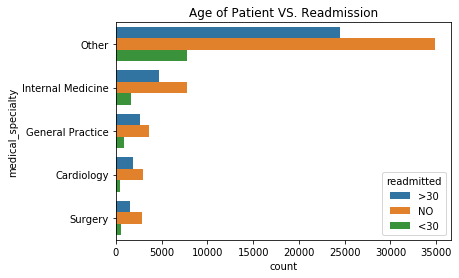

In [327]:
sns.countplot(y= diabdata['medical_specialty'], hue = diabdata['readmitted']).set_title('Age of Patient VS. Readmission')

### Feature Engineering - Diagnosis 
- Grouping values within feature: IDC code (based on first 3 characters)

001–139: infectious and parasitic diseases
140–239: neoplasms
240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
280–289: diseases of the blood and blood-forming organs
290–319: mental disorders
320–389: diseases of the nervous system and sense organs
390–459: diseases of the circulatory system
460–519: diseases of the respiratory system
520–579: diseases of the digestive system
580–629: diseases of the genitourinary system
630–679: complications of pregnancy, childbirth, and the puerperium
680–709: diseases of the skin and subcutaneous tissue
710–739: diseases of the musculoskeletal system and connective tissue
740–759: congenital anomalies
760–779: certain conditions originating in the perinatal period
780–799: symptoms, signs, and ill-defined conditions
800–999: injury and poisoning
E and V codes: external causes of injury and supplemental classification

In [328]:
# Converting IDC9 iagnostic codes  to characters

diags = ['diag_1','diag_2','diag_3']
for diag in diags:
    diagt = str(diag + '_temp')
    diabdata[diagt] = diabdata[diag].apply(lambda x : idc_to_group(x))

Text(0.5, 1.0, 'Primary Diagnosis')

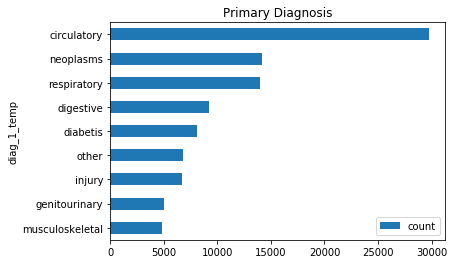

In [329]:
diabdata.groupby('diag_1_temp').agg({'diag_1':['count']})['diag_1'].sort_values('count').plot.barh() 
#,ascending=False
plt.title('Primary Diagnosis')

Text(0.5, 1.0, 'Primary Diag. VS. Readmission')

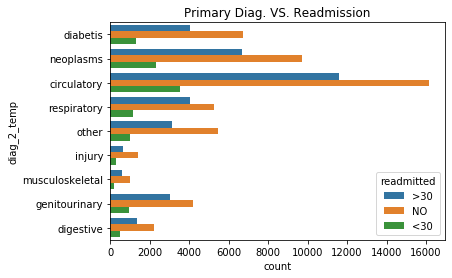

In [330]:
sns.countplot(y= diabdata['diag_2_temp'], hue = diabdata['readmitted']).set_title('Primary Diag. VS. Readmission')

Text(0.5, 1.0, 'Secondary Diagnosis')

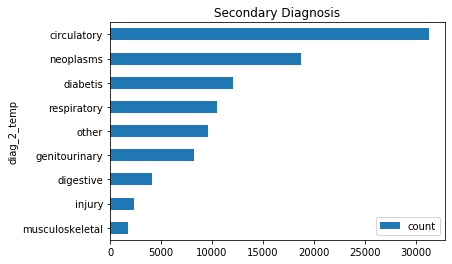

In [331]:
diabdata.groupby('diag_2_temp').agg({'diag_2':['count']})['diag_2'].sort_values('count').plot.barh()
plt.title('Secondary Diagnosis')

Text(0.5, 1.0, 'Third Diagnosis')

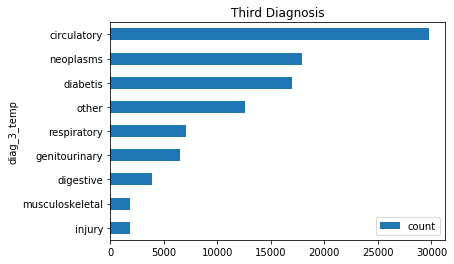

In [332]:
diabdata.groupby('diag_3_temp').agg({'diag_3':['count']})['diag_3'].sort_values('count').plot.barh()
plt.title('Third Diagnosis')

In [333]:
# Convert age range to ages
diabdata['newage'] = diabdata['age'].apply(lambda x: age_to_aveage(x) )
diabdata.newage.value_counts()

75    25394
65    21992
55    16891
85    16602
45     9415
35     3606
95     2661
25     1508
15      468
5        64
Name: newage, dtype: int64

In [334]:
# Transform the target variable to those admitted before 30 days and others
diabdata.readmitted = diabdata.readmitted.apply(lambda x : 1 if x =='<30' else 0)

## Removing multiple visit for each patient that is indicated by patient_nbr
This ensures that observations are independent

In [335]:
print('The unique number of patients, keep only these rows? ')
diabdata.patient_nbr.value_counts().count()

diabdata = diabdata.drop_duplicates(subset= ['patient_nbr'], keep = 'first') 

The unique number of patients, keep only these rows? 


In [336]:
diabdata.to_csv('cleaned_full_features.csv')

In [337]:
diabdata1= pd.read_csv('cleaned_full_features.csv',index_col=0)

## Dropping Feature Columns

- patient_nbr: 
- encounter_id:
- payer_code: 
- max_glu_serum: 
- weight: Too many missing value
-
-


In [338]:
# Drop columns that are not needed

# cols_to_drop = ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
#        'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
#        'time_in_hospital', 'payer_code', 'medical_specialty',
#        'num_lab_procedures', 'num_procedures', 'num_medications',
#        'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
#        'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
#        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
#        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
#        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
#        'tolazamide', 'examide', 'citoglipton', 'insulin',
#        'glyburide-metformin', 'glipizide-metformin',
#        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
#        'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
#        'newage']
cols_to_drop = ['encounter_id', 'patient_nbr', 'age', 'weight', 'admission_type_id',
                'payer_code', 'change','gender','diabetesMed',
                'num_lab_procedures', 'num_procedures', 
                'number_outpatient', 'number_emergency', 'number_inpatient', 
                'number_diagnoses', 'max_glu_serum',
                'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone','diag_1','diag_2','diag_3',
                'diag_2_temp','diag_3_temp']

# second round: include: num_medications, 'medical_specialty',

diabdata.drop(cols_to_drop, inplace= True, axis = 1)



In [339]:
# Save data before modification dummification
diabdata.to_csv('before_dummies.csv')

## One Hot Encoing of categorical features

In [340]:
diabdata2 = pd.read_csv('before_dummies.csv',index_col=0)
diabdata2.columns

Index(['race', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_medications', 'A1Cresult',
       'readmitted', 'diag_1_temp', 'newage'],
      dtype='object')

In [341]:
prefix = 'class1'
step1 = pd.get_dummies(diabdata2['diag_1_temp'], prefix = 'class1')

diabdata2 = pd.concat([diabdata2,step1], axis=1)
diabdata2.drop('diag_1_temp',1,inplace=True)
diabdata2.drop(str(prefix+'_'+'diabetis'),axis=1,inplace=True)

In [342]:
diabdata2.shape

(69340, 17)

In [343]:
print(diabdata2.shape)
diabdata2.head()

(69340, 17)


,race,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_medications,A1Cresult,readmitted,newage,class1_circulatory,class1_digestive,class1_genitourinary,class1_injury,class1_musculoskeletal,class1_neoplasms,class1_other,class1_respiratory
1,Caucasian,home,emergency,3,Other,18,None,0,15,0,0,0,0,0,1,0,0
2,AfricanAmerican,home,emergency,2,Other,13,None,0,25,0,0,0,0,0,0,1,0
3,Caucasian,home,emergency,2,Other,16,None,0,35,0,0,0,0,0,1,0,0
4,Caucasian,home,emergency,1,Other,8,None,0,45,0,0,0,0,0,1,0,0
5,Caucasian,home,clin_ref,3,Other,16,None,0,55,1,0,0,0,0,0,0,0


In [344]:
prefix = 'class3'
step3 = pd.get_dummies(diabdata2['race'], prefix = 'class3')# drop_first=True

diabdata2 = pd.concat([diabdata2,step3], axis=1)
diabdata2.drop('race',1,inplace=True)
diabdata2.drop(str(prefix+'_'+'AfricanAmerican'),axis=1,inplace=True)
diabdata2.shape

(69340, 19)

In [345]:
prefix = 'class4'
step4 = pd.get_dummies(diabdata2['medical_specialty'], prefix = 'class4')

diabdata2 = pd.concat([diabdata2,step4], axis=1)
diabdata2.drop('medical_specialty',1,inplace=True)
diabdata2.drop(str(prefix+'_'+'Cardiology'),axis=1,inplace=True)
diabdata2.shape

(69340, 22)

In [347]:
prefix = 'class6'
step6 = pd.get_dummies(diabdata2['discharge_disposition_id'], prefix = 'class6')

diabdata2 = pd.concat([diabdata2,step6], axis=1)
diabdata2.drop('discharge_disposition_id',1,inplace=True)
diabdata2.drop(str(prefix+'_'+'home'),axis=1,inplace=True)
diabdata2.shape

(69340, 22)

In [348]:
prefix = 'class7'
step7 = pd.get_dummies(diabdata2['admission_source_id'], prefix = 'class7')

diabdata2 = pd.concat([diabdata2,step7], axis=1)
diabdata2.drop('admission_source_id',1,inplace=True)
diabdata2.drop(str(prefix+'_'+'emergency'),axis=1,inplace=True)
diabdata2.shape

(69340, 26)

In [349]:
prefix = 'class8'
step8 = pd.get_dummies(diabdata2['A1Cresult'], prefix = 'class8')

diabdata2 = pd.concat([diabdata2,step8], axis=1)
diabdata2.drop('A1Cresult',1,inplace=True)
diabdata2.drop(str(prefix+'_'+'None'),axis=1,inplace=True)
diabdata2.shape

(69340, 28)

In [350]:
diabdata2.columns

Index(['time_in_hospital', 'num_medications', 'readmitted', 'newage',
       'class1_circulatory', 'class1_digestive', 'class1_genitourinary',
       'class1_injury', 'class1_musculoskeletal', 'class1_neoplasms',
       'class1_other', 'class1_respiratory', 'class3_Caucasian',
       'class3_Missing', 'class3_Other', 'class4_General Practice',
       'class4_Internal Medicine', 'class4_Other', 'class4_Surgery',
       'class6_other', 'class7_clin_ref', 'class7_hospital', 'class7_other',
       'class7_phys_ref', 'class7_snf', 'class8_>7', 'class8_>8',
       'class8_Norm'],
      dtype='object')

In [351]:
# Interaction Terms - Time in Hospital & Diagnosis
# diabdata2.head()
# diabdata2['class1_circulatory'].map(lambda x,y: x*y,diabdata2['class1_circulatory'],diabdata2['time_in_hospital'])

In [352]:
diabdata2.to_csv('before_model_diabdata.csv')

## Logistic Regression Model 

In [383]:
diabdata3 = pd.read_csv('before_model_diabdata.csv',index_col=0)
diabdata3.columns

Index(['time_in_hospital', 'num_medications', 'readmitted', 'newage',
       'class1_circulatory', 'class1_digestive', 'class1_genitourinary',
       'class1_injury', 'class1_musculoskeletal', 'class1_neoplasms',
       'class1_other', 'class1_respiratory', 'class3_Caucasian',
       'class3_Missing', 'class3_Other', 'class4_General Practice',
       'class4_Internal Medicine', 'class4_Other', 'class4_Surgery',
       'class6_other', 'class7_clin_ref', 'class7_hospital', 'class7_other',
       'class7_phys_ref', 'class7_snf', 'class8_>7', 'class8_>8',
       'class8_Norm'],
      dtype='object')

In [384]:

from sklearn.linear_model    import LogisticRegression, SGDClassifier
from sklearn.metrics         import accuracy_score, f1_score, recall_score
from sklearn.metrics         import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn                 import datasets
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split


### Standardize Data 
- Only if needed
- Standardize features by removing the mean and scaling to unit variance

- The standard score of a sample x is calculated as:

- *z = (x - u) / s*

In [385]:
# # Create the standardized version of the datasets

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)


### Create Train and Test data
- To avoid overfitting it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test.

- Split the ***diabetes*** dataset into random train and test subsets
- There is option to stratify by setting 

In [386]:

X = diabdata3.drop('readmitted',1)
y = diabdata3.readmitted

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)

(69340, 27) (69340,)


## Cross Validation

- Cross-validation is used to test the generalizability of the model

In [387]:



# First Run
diabetes_model = LogisticRegression(solver='liblinear',class_weight='balanced')
diabetes_model.fit(X_train,y_train)

# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(diabetes_model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.603


In [388]:
y_pred = diabetes_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.62      0.74     18905
           1       0.12      0.53      0.20      1897

    accuracy                           0.61     20802
   macro avg       0.53      0.57      0.47     20802
weighted avg       0.86      0.61      0.69     20802



## Grid Search - Hyperparameter Tuning

In [393]:

# Create regularization hyperparameter space
grid_params={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

grid_log = LogisticRegression(solver='liblinear',class_weight='balanced')
gridsearch_logit = GridSearchCV(grid_log, grid_params, cv = 5)
gridsearch_logit.fit(X_train,y_train)
y_pred_grid = gridsearch_logit.predict(X_test)


In [394]:
print('Gridsearch Object Best Score: ',gridsearch_logit.best_params_)

Gridsearch Object Best Score:  {'C': 0.01, 'penalty': 'l1'}


In [395]:
y_test.value_counts()

0    18905
1     1897
Name: readmitted, dtype: int64

In [396]:
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

           0       0.93      0.62      0.74     18905
           1       0.12      0.53      0.20      1897

    accuracy                           0.61     20802
   macro avg       0.53      0.57      0.47     20802
weighted avg       0.86      0.61      0.69     20802



In [397]:
gridsearch_logit.best_score_

0.6154353290205612

Text(0.5, 0, 'Magnitude')

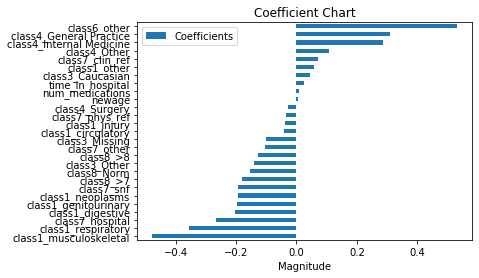

In [398]:
coefdf = pd.DataFrame(diabetes_model.coef_)
coefdf.columns = X_train.columns.tolist()
coefdf = coefdf.transpose() #.columns = ['Coefficients']
coefdf.columns = ['Coefficients']
coefdf.sort_values('Coefficients').plot.barh()
plt.title('Coefficient Chart')
plt.xlabel('Magnitude')

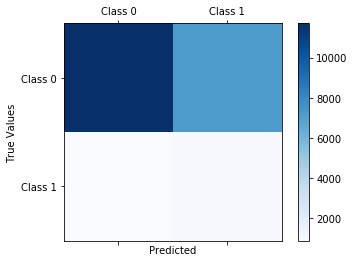

In [399]:

conf_matrix = confusion_matrix(y_test, y_pred_grid)
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax  = fig.add_subplot(111)
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.ylabel('True Values')
plt.xlabel('Predicted')
plt.show()

In [400]:

confusion_matrix(y_test, y_pred)

array([[11691,  7214],
       [  889,  1008]])

In [401]:
# Calculate the predicted values and percentiles

y_pred       = diabetes_model.predict(X_test)
y_pred_proba = diabetes_model.predict_proba(X_test)

pd.Series(y_test).index = pd.Series(y_pred).index
predictions = pd.concat([pd.Series(y_test),pd.Series(y_pred),pd.DataFrame(y_pred_proba)],axis=1)
predictions.columns = ['readmitted','predicted','prob_not_readmitted','prob_readmitted']

In [402]:
# Calculate perdiction based on a range of cut-off values

predictions['pred_55p']= predictions.prob_readmitted.map(lambda x : 1 if x > 0.55 else 0 )
predictions['pred_50p']= predictions.prob_readmitted.map(lambda x : 1 if x > 0.50 else 0 )
predictions['pred_45p']= predictions.prob_readmitted.map(lambda x : 1 if x > 0.45 else 0 )
predictions['pred_40p']= predictions.prob_readmitted.map(lambda x : 1 if x > 0.40 else 0 )
predictions['pred_35p']= predictions.prob_readmitted.map(lambda x : 1 if x > 0.35 else 0 )
predictions['pred_30p']= predictions.prob_readmitted.map(lambda x : 1 if x > 0.30 else 0 )


In [403]:
# See the effect of the different cut off percentages from 30 to 55 percent

mat_list = ['pred_30p','pred_35p','pred_40p','pred_45p','pred_50p','pred_55p']

[print(confusion_matrix(predictions.readmitted,predictions[pred] )) for pred in mat_list]


[[   85 18820]
 [    3  1894]]
[[  858 18047]
 [   48  1849]]
[[ 3571 15334]
 [  211  1686]]
[[ 8154 10751]
 [  566  1331]]
[[11691  7214]
 [  889  1008]]
[[13779  5126]
 [ 1146   751]]


[None, None, None, None, None, None]

## Decile Analysis
- Decile analysis is created to test the model’s ability to predict the intended outcome.
- A range should be observed from most likely to least likely prediction 

In [404]:

prange,bins = pd.qcut(predictions['prob_readmitted'],10,retbins=True)

bins[0]  -= 0.001
bins[-1] += 0.001

bins_labels = ['%d.(%0.2f,%0.2f]'%(x[0],x[1][0],x[1][1]) for x in enumerate(zip(bins[:-1],bins[1:]))]
bins_labels[0]                 = bins_labels[0].replace('(','[')

predictions['Decile']          = pd.cut(predictions['prob_readmitted'],bins=bins,labels=bins_labels)
predictions['Patients']        = 1
predictions['Not_Readmitted']  = 1-predictions['readmitted']
predictions['Readmitted']      =   predictions['readmitted']
predictions['Prob_Min']        = prange.apply(lambda x : x.left)
predictions['Prob_Max']        = prange.apply(lambda x : x.right)
    
summary  = predictions.groupby(['Decile'])[['Readmitted','Not_Readmitted','Patients','Prob_Min','Prob_Max']].sum()
# summary['Prob_MinMax'] = ['%0.2f - %0.2f'%(x[1][0],x[1][1]) for x in enumerate(zip(bins[:-1],bins[1:]))]
summary['Prob_Min']    = [x for x in bins[:-1]]
summary['Prob_Max']    = [x for x in bins[1: ]]

summary  = summary.sort_index(ascending=False)

    
summary['ReadmittedRate_pct']  =summary['Readmitted']/summary['Patients']
summary['Lift'] = (summary['Readmitted']/summary['Patients'])/.10
summary

,Readmitted,Not_Readmitted,Patients,Prob_Min,Prob_Max,ReadmittedRate_pct,Lift
Decile,,,,,,,
"9.(0.62,0.76]",281,1799,2080,0.619785,0.761897,0.135096,1.350962
"8.(0.58,0.62]",272,1809,2081,0.583146,0.619785,0.130706,1.307064
"7.(0.54,0.58]",239,1841,2080,0.542685,0.583146,0.114904,1.149038
"6.(0.50,0.54]",226,1854,2080,0.497725,0.542685,0.108654,1.086538
"5.(0.47,0.50]",184,1896,2080,0.468468,0.497725,0.088462,0.884615
"4.(0.45,0.47]",158,1922,2080,0.445806,0.468468,0.075962,0.759615
"3.(0.43,0.45]",147,1933,2080,0.426331,0.445806,0.070673,0.706731
"2.(0.40,0.43]",157,1923,2080,0.404541,0.426331,0.075481,0.754808
"1.(0.38,0.40]",127,1953,2080,0.376529,0.404541,0.061058,0.610577


In [405]:
confusion_matrix(predictions['readmitted'],predictions['predicted'])

array([[11691,  7214],
       [  889,  1008]])

[Text(0, 0, '0.[0.25,0.38]'),
 Text(0, 0, '1.(0.38,0.40]'),
 Text(0, 0, '2.(0.40,0.43]'),
 Text(0, 0, '3.(0.43,0.45]'),
 Text(0, 0, '4.(0.45,0.47]'),
 Text(0, 0, '5.(0.47,0.50]'),
 Text(0, 0, '6.(0.50,0.54]'),
 Text(0, 0, '7.(0.54,0.58]'),
 Text(0, 0, '8.(0.58,0.62]'),
 Text(0, 0, '9.(0.62,0.76]')]

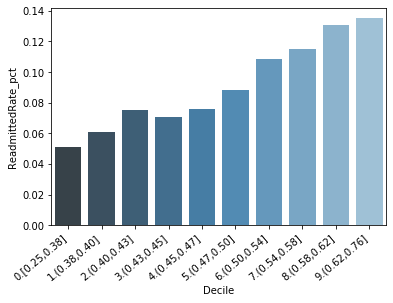

In [406]:
ax = sns.barplot(x=summary.index, y=summary.ReadmittedRate_pct, data=summary,palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


### Bootstrapping and SMOTE Synthetic Minority Over-Sampling Technique
- Upsampling minory class to create balanced dataset
- *conda install -c conda-forge imbalanced-learn*

In [408]:
from imblearn               import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

smote_ = SMOTE(random_state=42)

print('Resamplig Data with SMOTE')
X_res, y_res = smote_.fit_resample(X_train, y_train)

print('Original dataset shape %s'% y_train.shape[0])
print('Resampled dataset shape %s'% y_train.shape[0])

Resamplig Data with SMOTE
Original dataset shape 48538
Resampled dataset shape 48538


In [409]:
# Run Logistic Regression on the upsampled balanced train dataset

diab_logit_res = LogisticRegression(solver='liblinear') 

diab_logit_res.fit(X_res,y_res)

y_pred_res = diab_logit_res.predict(X_test)

print(classification_report(y_test, y_pred_res))


              precision    recall  f1-score   support

           0       0.91      0.81      0.86     18905
           1       0.10      0.21      0.14      1897

    accuracy                           0.76     20802
   macro avg       0.51      0.51      0.50     20802
weighted avg       0.84      0.76      0.79     20802



## Model Evaluation
- **Confusion Matrix**: a table showing correct predictions and types of incorrect predictions.

- **Accuracy**: Algorithms are designed to maximize accuracy and reduce error. 
    ***Not good for imbalanced dataset*** 
    
    
- **Precision**: the number of true positives divided by all positive prediction.

    Precision = True Positive / True Positive + False Positive
    
    Precision is also called Positive Predictive Value. It is a measure of 
    classifier’s exactness. Low precision indicates a high number of false positives.
    
- **Recall**: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.
-
- **F1 Score**: the weighted average of precision and recall.

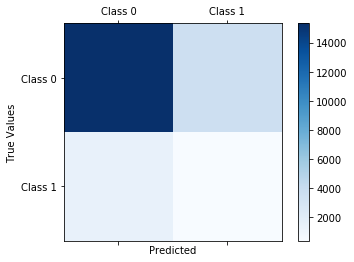

In [410]:
conf_matrix = confusion_matrix(y_test,y_pred_res )
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax  = fig.add_subplot(111)
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.ylabel('True Values')
plt.xlabel('Predicted')
plt.show()

In [411]:
confusion_matrix(y_test,y_pred)

array([[11691,  7214],
       [  889,  1008]])

In [412]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.62      0.74     18905
           1       0.12      0.53      0.20      1897

    accuracy                           0.61     20802
   macro avg       0.53      0.57      0.47     20802
weighted avg       0.86      0.61      0.69     20802



Treshold [2 1 0]


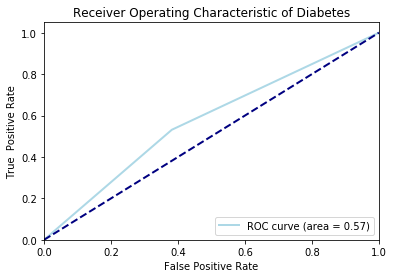

In [413]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, treshold = roc_curve(y_test, y_pred)
print('Treshold {}'.format(treshold))
roc_auc  = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='lightblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True  Positive Rate')
plt.title('Receiver Operating Characteristic of Diabetes')
plt.legend(loc='lower right')
plt.show()

## Significance of Coefficients 

In [414]:
import statsmodels.api as sm 

X_add_const_res = sm.add_constant(X_train)
sm_logit        = sm.Logit(y_train, X_train)
ans             = sm_logit.fit()
# print(ans.summary())

/Users/karolylajko/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.303477
         Iterations 7


In [415]:
ans.summary().tables[1]

table = pd.DataFrame(ans.summary().tables[1].data[1:])
table.columns = ['name','coef','std err','t value','p value','2.5% confidence','97.5% confidence']
table = table.astype({'name':str,'coef':float,'std err':float, 't value':float, 'p value':float,'2.5% confidence':float, '97.5% confidence':float})
table[table['p value']<0.05]  # those coefficients with 0 lying outside their CIs


,name,coef,std err,t value,p value,2.5% confidence,97.5% confidence
0,time_in_hospital,0.0194,0.006,3.125,0.002,0.007,0.032
1,num_medications,-0.0055,0.002,-2.488,0.013,-0.010,-0.001
2,newage,-0.0122,0.001,-13.299,0.000,-0.014,-0.010
3,class1_circulatory,-0.6091,0.054,-11.346,0.000,-0.714,-0.504
4,class1_digestive,-0.6998,0.072,-9.750,0.000,-0.840,-0.559
5,class1_genitourinary,-0.6364,0.086,-7.441,0.000,-0.804,-0.469
6,class1_injury,-0.4762,0.073,-6.510,0.000,-0.620,-0.333
7,class1_musculoskeletal,-0.8028,0.089,-8.991,0.000,-0.978,-0.628
8,class1_neoplasms,-0.6689,0.061,-10.899,0.000,-0.789,-0.549
9,class1_other,-0.4964,0.073,-6.754,0.000,-0.640,-0.352
